<a href="https://colab.research.google.com/github/YKG-123/Fantasy_football_ML_Random_forest_Regressor/blob/main/RB_Prev_Season_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import requests
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import pearsonr, spearmanr
import kagglehub
from kagglehub import KaggleDatasetAdapter
import statsmodels.api as sm

In [2]:
file_path = "weekly_player_stats_offense.csv"
file_path2 = "yearly_player_stats_offense.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "philiphyde1/nfl-stats-1999-2022",
  file_path,
)
df2 = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "philiphyde1/nfl-stats-1999-2022",
  file_path2,
)

import requests

years = range(2016, 2024)
all_adp = []

for y in years:
    url = f"https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year={y}&position=all"
    try:
        r = requests.get(url)
        r.raise_for_status()
        data = r.json()

        df_adp = pd.DataFrame(data["players"])
        df_adp["season"] = y
        all_adp.append(df_adp)
        print(f"{y} — {len(df_adp)} players loaded")
    except Exception as e:
        print(f"Error for {y}: {e}")

adp_all = pd.concat(all_adp, ignore_index=True)

adp_all["name"] = adp_all["name"].str.strip()

print(adp_all.head())


adp_all.to_json("historical_adp_ppr.json", orient="records")

adp_keep = adp_all[["name", "position", "team", "adp", "season"]].copy()

adp_keep["player_name_merge"] = (
    adp_keep["name"]
    .str.strip()
    .str.replace(r"\s+Jr\.?$", "", regex=True)
    .str.replace(r"\s+Sr\.?$", "", regex=True)
)


adp_all = (
    adp_keep
    .groupby(["season", "player_name_merge"], as_index=False)
    .agg({
        "adp": "first",
        }))

df["player_name_merge"] = (
    df["player_name"]
    .str.strip()
    .str.replace(r"\s+Jr\.?$", "", regex=True)
    .str.replace(r"\s+Sr\.?$", "", regex=True)
)

df= df.merge(adp_all, on=["season", "player_name_merge"], how="left")

print(df[["player_name", "season", "adp", "position", "team"]].head())


/tmp/ipython-input-3748354739.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 101M/101M [00:01<00:00, 87.9MB/s] 
/tmp/ipython-input-3748354739.py:8: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df2 = kagglehub.load_dataset(


Using Colab cache for faster access to the 'nfl-stats-1999-2022' dataset.
2016 — 188 players loaded
2017 — 184 players loaded
2018 — 197 players loaded
2019 — 200 players loaded
2020 — 203 players loaded
2021 — 211 players loaded
2022 — 157 players loaded
2023 — 202 players loaded
   player_id               name position team  adp adp_formatted  \
0       1886      Antonio Brown       WR  PIT  1.2          1.01   
1       1796        Julio Jones       WR  ATL  2.8          1.03   
2       2113  Odell Beckham Jr.       WR  NYG  3.4          1.03   
3       2297      David Johnson       RB  ARI  3.4          1.03   
4       2280        Todd Gurley       RB  LAR  6.3          1.06   

   times_drafted  high  low  stdev  bye  season  
0            454     1    4    0.5    5    2016  
1            348     1    6    0.9    5    2016  
2            512     1   10    1.2   14    2016  
3            146     1    7    1.5    8    2016  
4            470     1   12    1.8    8    2016  
     play

In [3]:
df=df[df["season"]>=2016]
df=df[df["season"]<=2022]
print(df["adp"])
df2=df2[df2["position"]=="RB"]
df2=df2[df2["season"]>=2016]
df2=df2[df2["season"]<=2022]
df2=df2[df2["season_average_fantasy_points_ppr"]>5]
df2["season_average_fantasy_points_ppr"].describe()

15557    68.5
15558    68.5
15559    68.5
15560    68.5
15561    68.5
         ... 
48545     NaN
48546     NaN
48547     NaN
48548     NaN
48549     NaN
Name: adp, Length: 32993, dtype: float64


,season_average_fantasy_points_ppr
count,654.000000
mean,10.868379
std,4.775897
min,5.010000
25%,7.302500
50%,9.765000
75%,13.475000
max,29.700000


0 count    242.000000
mean      11.497085
std        5.038190
min       -0.200000
25%        7.864904
50%       10.853125
75%       14.464423
max       29.075000
Name: fantasy_points_ppr, dtype: float64
Train R²: 0.544
Test R²: 0.528


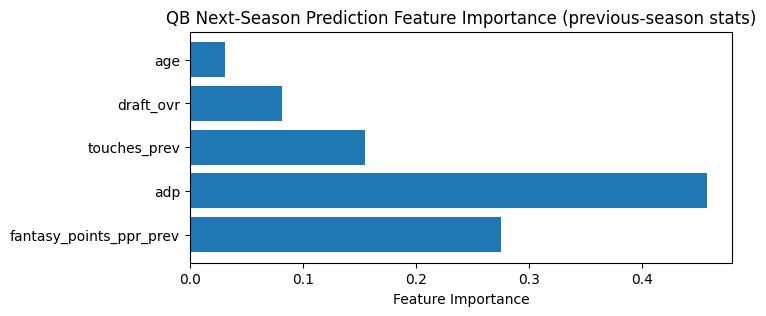


Top predictions (sorted by predicted value):
      player_id         player_name  season  target_season_actual  \
52   00-0029141       Alfred Morris    2018              5.918182   
98   00-0030513     Latavius Murray    2021              7.100000   
410  00-0034440      Justin Jackson    2021              6.553846   
249  00-0032940  DeAndre Washington    2020              5.633333   
114  00-0031045         Carlos Hyde    2021              3.981818   
68   00-0030288        Rex Burkhead    2017             11.475000   
408  00-0034440      Justin Jackson    2019              4.457143   
251  00-0032972     Devontae Booker    2018              5.425000   
254  00-0032972     Devontae Booker    2021              9.006250   
2    00-0023500          Frank Gore    2019              6.326667   
246  00-0032940  DeAndre Washington    2017              5.600000   
24   00-0027029        LeSean McCoy    2020              3.525000   
77   00-0030404      Chris Thompson    2020              

In [4]:

df = df[df['position'] == 'RB'].copy()

df['week'] = df['week'].astype(int)
df['season'] = df['season'].astype(int)
df["adp"]=df["adp"].replace(0,10000)

if 'fantasy_points_ppr' in df.columns:
    df['fantasy_points_ppr'] = df['fantasy_points_ppr'].astype(float)
    fantasy_points_col = 'fantasy_points_ppr'
elif 'season_average_fantasy_points_ppr' in df.columns:
     df['season_average_fantasy_points_ppr'] = df['season_average_fantasy_points_ppr'].astype(float)
     fantasy_points_col = 'season_average_fantasy_points_ppr'
else:
    raise KeyError("No suitable fantasy points column found in the dataframe.")


numeric_cols = df.select_dtypes(include='number').columns.tolist()
group_cols = ['player_id', 'season']
agg_cols = {c: 'mean' for c in numeric_cols if c not in group_cols
            and c != "fantasy_points_ppr" and c != "draft_round" and c != "age"
             and c != "years_exp" and c != "draft_pick" and c != "adp"}
agg_cols['fantasy_points_ppr'] = 'mean'
agg_cols['draft_round'] = 'first'
agg_cols['age'] = 'first'
agg_cols['years_exp'] = 'first'
agg_cols['draft_ovr'] = 'first'
agg_cols['adp'] = 'first'


season_agg = df.groupby(group_cols).agg(
    agg_cols
).reset_index()
if 'player_name' in df.columns:
    names = df.groupby(group_cols)['player_name'].first().reset_index()
    season_agg = season_agg.merge(names[['player_id', 'season', 'player_name']], on=['player_id', 'season'], how='left')


prev = season_agg.copy()
prev['season'] = prev['season'] + 1
prev = prev.add_suffix('_prev')
curr = season_agg.copy()
merged_prev_next = curr.merge(
    prev,
    left_on=['player_id', 'season'],
    right_on=['player_id_prev', 'season_prev'],
    how='inner'  )

features = [     'fantasy_points_ppr_prev', 'adp',
            "touches_prev","draft_ovr","age"
]


if 'fantasy_points_ppr' in merged_prev_next.columns:
    target = 'fantasy_points_ppr'
elif fantasy_points_col in merged_prev_next.columns:
    target = fantasy_points_col
else:
    raise KeyError("No suitable target column found in the merged dataframe.")


model_df = merged_prev_next.dropna(subset=features + [target]).copy()
X = model_df[features]
X = X.replace(0, 10000)

y = model_df[target]
identifiers = model_df[['player_id', 'season', 'player_name']] if 'player_name' in model_df.columns else model_df[['player_id', 'season']]

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, identifiers.index, test_size=0.3, random_state=42
)

model = RandomForestRegressor(
    n_estimators=650,
    min_samples_split=7,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    max_depth=7,
    max_features="sqrt"
)
print(y.isna().sum(), y.describe())

model.fit(X_train, y_train)

train_r2 = model.score(X_train, y_train)
test_r2 = model.score(X_test, y_test)
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")

importances = model.feature_importances_
plt.figure(figsize=(7, max(3, len(features) * 0.5)))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("QB Next-Season Prediction Feature Importance (previous-season stats)")
plt.show()

preds = model.predict(X)
results = pd.DataFrame({
    'player_id': identifiers.loc[X.index, 'player_id'],
    'player_name': identifiers.loc[X.index, 'player_name'] if 'player_name' in identifiers.columns else np.nan,
    'season': identifiers.loc[X.index, 'season'],
    'target_season_actual': y,
    'predicted_from_prev_season': preds,
    'error': y - preds,
    'adp': model_df['adp']
}, index=X.index)

print("\nTop predictions (sorted by predicted value):")
print(results.sort_values('predicted_from_prev_season', ascending=True).head(15))


In [5]:
results["adp"]=results["adp"].replace(0,np.inf)
results["adp_rank"] = results.groupby("season")["adp"].rank(method="min", ascending=True)

results["predicted_rank"] = results.groupby("season")["predicted_from_prev_season"] \
                                   .rank(method="min", ascending=False)

results["rank_diff"] = results["predicted_rank"] - results["adp_rank"]

print(results.sort_values(["season", "rank_diff"],ascending=False).head(15))


      player_id          player_name  season  target_season_actual  \
420  00-0034681        Chase Edmonds    2022              6.011111   
541  00-0036919     Kenneth Gainwell    2022              6.125000   
488  00-0035657        Damien Harris    2022              8.081818   
533  00-0036567      Elijah Mitchell    2022              5.200000   
544  00-0036997     Javonte Williams    2022             10.250000   
281  00-0033280  Christian McCaffrey    2022             19.577778   
286  00-0033293          Aaron Jones    2022             14.329412   
444  00-0034844       Saquon Barkley    2022             17.070588   
513  00-0036265          A.J. Dillon    2022              9.858824   
526  00-0036414            Cam Akers    2022             10.523077   
538  00-0036875  Rhamondre Stevenson    2022             14.594118   
347  00-0033906         Alvin Kamara    2022             13.846667   
352  00-0033923          Kareem Hunt    2022              7.458824   
269  00-0033045     

Train R²: 0.681
Test R²: 0.635


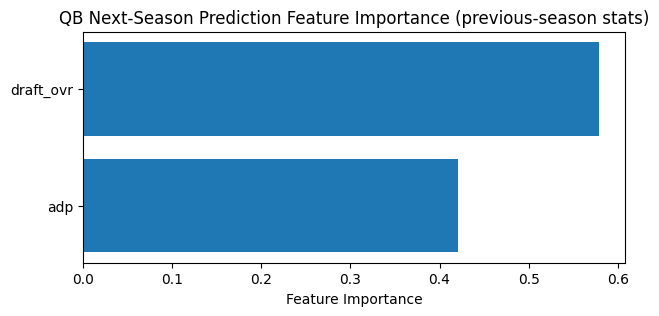

In [6]:
df_rookie=df[df["years_exp"]==0]
df_rookie=df_rookie[df_rookie["position"]=="RB"]
df_rookie=df_rookie[df_rookie["season"]>=2016]
df_rookie=df_rookie[df_rookie["season"]<=2024]
features_rookie = [                "adp","draft_ovr"
]
df_rookie=df_rookie.groupby(["player_name", "season"]).agg({
    "adp": "first",
    "draft_ovr": "first",
    "fantasy_points_ppr": "mean"
})
X = df_rookie[features_rookie]

y = df_rookie["fantasy_points_ppr"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
RB_rookie_model = RandomForestRegressor(
    n_estimators=900,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
)
RB_rookie_model.fit(X_train, y_train)
train_r2 = RB_rookie_model.score(X_train, y_train)
test_r2 = RB_rookie_model.score(X_test, y_test)
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
importances = RB_rookie_model.feature_importances_
plt.figure(figsize=(7, max(3, len(features_rookie) * 0.5)))
plt.barh(features_rookie, importances)
plt.xlabel("Feature Importance")
plt.title("QB Next-Season Prediction Feature Importance (previous-season stats)")
plt.show()


In [7]:
print(df_rookie["adp"])


player_name         season
A.J. Dillon         2020      111.9
Aaron Jones         2017        NaN
Alex Collins        2016        NaN
Alexander Mattison  2019      127.3
Alvin Kamara        2017      140.0
                              ...  
Wendell Smallwood   2016        NaN
Zack Moss           2020       83.7
Zamir White         2022      130.5
Zander Horvath      2022        NaN
Zonovan Knight      2022        NaN
Name: adp, Length: 177, dtype: float64


In [11]:
load_dataset = kagglehub.load_dataset
file_path = "weekly_player_stats_offense.csv"
df_real = load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "philiphyde1/nfl-stats-1999-2022",
    file_path,
)

df_real = df_real[df_real["season"] == 2024].copy()
df_real["season"] = 2025
df_real = df_real[df_real["position"] == "RB"]

years = 2025
years_list = [years] if isinstance(years, int) else list(years)
all_adp = []

for y in years_list:
    url = f"https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year={y}&position=all"
    r = requests.get(url)
    r.raise_for_status()
    df_adp = pd.DataFrame(r.json()["players"])
    df_adp["season"] = y
    all_adp.append(df_adp)
    print(f"{y} — {len(df_adp)} players loaded")

adp_all = pd.concat(all_adp, ignore_index=True)
adp_all["name"] = adp_all["name"].str.strip()

adp_keep = adp_all[["name", "position", "team", "adp", "season"]].copy()
adp_keep = adp_keep[adp_keep["position"] == "RB"]

def normalize_name(s: pd.Series) -> pd.Series:
    return (
        s.fillna("")
         .str.strip()
         .str.replace(r"\s+Jr\.?$", "", regex=True)
         .str.replace(r"\s+Sr\.?$", "", regex=True)
         .str.replace(r"\s+III?$", "", regex=True)
         .str.replace(r"[^\w\s\-']", "", regex=True)
         .str.replace(r"\s+", " ", regex=True)
    )

adp_keep["player_name_merge"] = normalize_name(adp_keep["name"])
df_real["player_name_merge"] = normalize_name(df_real["player_name"])

adp_non_sum = (
    adp_keep
    .groupby(["season", "player_name_merge"], as_index=False)
    .agg({"adp": "first"})
)

df_real = df_real.merge(adp_non_sum, on=["season", "player_name_merge"], how="outer")


rb = df_real[df_real["position"] == "RB"].copy()

for col in ["fantasy_points_ppr", "touches", "draft_pick", "years_exp"]:
    if col not in rb.columns:
        rb[col] = np.nan

RB_stats = (
    rb.groupby(["player_name", "season"], as_index=False)
      .agg({
          "fantasy_points_ppr": "mean",
          "touches": "mean",
          "draft_ovr": "first",
          "years_exp": "first",
          "adp": "first",
          "age": "first"
      })
      .rename(columns={
          "fantasy_points_ppr": "fantasy_points_ppr_prev",
          "touches": "touches_prev",
      })
)

RB_adps = (
    rb.groupby(["player_name", "season"], as_index=False)
      .agg({
          "adp": "first",
          "position": "first",
          "team": "first",
      })
)

RB_2025 = RB_stats.merge(RB_adps, on=["player_name", "season"], how="left")

adp_for_merge = adp_non_sum.rename(
    columns={"adp": "adp_for_rank", "player_name_merge": "player_name"}
)
RB_2025 = RB_2025.merge(adp_for_merge, on=["player_name", "season"], how="left")

if "adp" in RB_2025.columns:
    RB_2025["adp"] = RB_2025["adp"].replace(0, 200)
if "adp_for_rank" in RB_2025.columns:
    RB_2025["adp_for_rank"] = RB_2025["adp_for_rank"].replace(0, 200)

RB_2025.rename(columns={"adp_x": "adp"}, inplace=True)
print(RB_2025[["player_name", "season", "fantasy_points_ppr_prev", "touches_prev", "draft_ovr", "years_exp", "adp", "adp_for_rank"]]
      .sort_values(["season", "player_name"])
      .head(20))

if 'features' in globals() and 'model' in globals():
    X_input = RB_2025[features]
    print("NaN count per feature:\n", X_input.isna().sum())
    print("Any inf?", np.isinf(X_input.to_numpy()).any())
    RB_2025["predicted_target_season"] = model.predict(X_input.values)
    print(RB_2025[["player_name", "predicted_target_season", "adp_for_rank"]]
          .sort_values("predicted_target_season", ascending=False)
          .head(15))
else:
    print("Note: Define `features` and `model` to run predictions. For example:")
    print("features = ['fantasy_points_ppr_prev', 'touches_prev', 'draft_pick', 'years_exp', 'adp_for_rank']")
    print("# Fit your model, then:")
    print("# RB_2025['predicted_target_season'] = model.predict(RB_2025[features].values)")


/tmp/ipython-input-424747122.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df_real = load_dataset(


Using Colab cache for faster access to the 'nfl-stats-1999-2022' dataset.
2025 — 0 players loaded


KeyError: 'name'

In [ ]:
RB_2025=RB_2025[["player_name","fantasy_points_ppr_prev",
                 "predicted_target_season","touches_prev","adp_for_rank"]]
print(RB_2025.head(50))


In [ ]:
rookie_rbs=pd.DataFrame({"player_name":["Ashton Jeanty",
                                        "Omarion Hampton",
                                        "TreVeyon Henderson",
                                        "RJ Harvey",
                                        "Kaleb Johnson",
                                        "Quinshon Judkins",
                                        "Cam Skattebo",
                                        "Jaydon Blue",
                                        "Dylan Sampson",
                                        "Bhayshul Tuten",
                                        "Tahj Brooks",
                                        "Jacory Croskey-Merritt",
                                        "Woody Marks"],
                         "adp":[11,42,55.1,63.2,74.8,119.4,122.6,140.1,147.5,154.3,155.7,159.5,161.9],
                         "draft_ovr":[6,22,38,60,83,36,99,140,120,98,177,221,110]})
rookie_rbs["predicted_target_season"]=RB_rookie_model.predict(rookie_rbs[features_rookie].values)
print(rookie_rbs)
rookie_rbs=rookie_rbs.rename(columns={"adp":"adp_for_rank"})

RB_2025 = pd.concat([RB_2025, rookie_rbs], ignore_index=True)
print(rookie_rbs.describe())
print(RB_2025.describe())

In [ ]:
vet_mask = RB_2025["fantasy_points_ppr_prev"].notna()
rookie_mask = ~vet_mask
veteran_preds = RB_2025.loc[vet_mask, "predicted_target_season"]
sigma_vet = veteran_preds.std()

rookie_preds = RB_2025.loc[rookie_mask, "predicted_target_season"]
mu_rook = rookie_preds.mean()
sigma_rook = rookie_preds.std()

def match_variance_keep_mean(x, sigma_old, sigma_new, mu_keep):
    return (x - mu_keep) / sigma_old * sigma_new + mu_keep

RB_2025.loc[rookie_mask, "predicted_target_season"] = pd.Series(
    match_variance_keep_mean(
        rookie_preds.values,
        sigma_rook,
        sigma_vet,
        mu_rook
    ),
    index=RB_2025.index[rookie_mask]
)

print("Veteran mean/std:", veteran_preds.mean(), veteran_preds.std())
print("Rookie mean/std after scaling:",
      RB_2025.loc[rookie_mask, "predicted_target_season"].mean(),
      RB_2025.loc[rookie_mask, "predicted_target_season"].std())


In [ ]:

target_mean = 10.868379
col = "predicted_target_season"

drafted_mask = (
    RB_2025["adp_for_rank"].notna()
    & np.isfinite(RB_2025["adp_for_rank"])
    & (RB_2025["adp_for_rank"] != 200)
)

current_mean = RB_2025.loc[drafted_mask, col].mean()

RB_2025.loc[drafted_mask, col] = (
    (RB_2025.loc[drafted_mask, col] - current_mean)
    + target_mean
)

print("New mean (drafted):", RB_2025.loc[drafted_mask, col].mean())
print("New std (drafted):", RB_2025.loc[drafted_mask, col].std())

In [ ]:
RB_2025.loc[RB_2025["player_name"] == "Devon Achane", "adp_for_rank"] = 8.7
RB_2025.loc[RB_2025["player_name"] == "J.K. Dobbins", "adp_for_rank"] = 90.2

xcol = "adp_for_rank"
ycol = "predicted_target_season"

plot_df = RB_2025[[xcol, ycol, "player_name"]].copy()

plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[xcol, ycol])
plot_df = plot_df[(plot_df[xcol] >= 1) & (plot_df[xcol] <= 400)]

if plot_df[xcol].nunique() < 2 or len(plot_df) < 3:
    print("Not enough clean data to fit a trendline.")
else:
    x = plot_df[xcol].to_numpy(dtype=float)
    y = plot_df[ycol].to_numpy(dtype=float)
    names = plot_df["player_name"].to_numpy()

    x_c = x - np.mean(x)
    y_c = y - np.mean(y)
    try:
        m, b = np.polyfit(x_c, y_c, 1)
        b = b + np.mean(y) - m * np.mean(x)
    except np.linalg.LinAlgError:
        denom = np.dot(x_c, x_c)
        if denom == 0:
            print("Cannot fit a line: zero variance in x after cleaning.")
            m, b = 0.0, np.mean(y)
        else:
            m = np.dot(x_c, y_c) / denom
            b = np.mean(y) - m * np.mean(x)

    y_pred = m * x + b
    residuals = y - y_pred
    std_dev = residuals.std(ddof=1)

    order = np.argsort(x)
    xs = x[order]
    yps = y_pred[order]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.7, label="Players")
    plt.plot(xs, yps, color="red", linewidth=2, label=f"Trendline (m={m:.3f})")
    plt.fill_between(xs, yps - std_dev, yps + std_dev, color="red", alpha=0.2, label="±1σ residuals")

    for xi, yi, name in zip(x, y, names):
        plt.annotate(name, (xi, yi), fontsize=8, alpha=0.7, xytext=(3, 3), textcoords="offset points")

    plt.xlabel("Average Draft Position (ADP)")
    plt.ylabel("Predicted Fantasy Points")
    plt.title("RB ADP vs Fantasy Points — 2025 Season")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
RB_2025["adp_for_rank"] = RB_2025["adp_for_rank"].fillna(200)
RB_2025.loc[RB_2025["player_name"] == "Devon Achane", "adp_for_rank"] = 8.7
RB_2025.loc[RB_2025["player_name"] == "J.K. Dobbins", "adp_for_rank"] = 90.2

xcol = "adp_for_rank"
ycol = "predicted_target_season"

plot_df = RB_2025[[xcol, ycol, "player_name"]].copy()

plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[xcol, ycol])
plot_df = plot_df[(plot_df[xcol] >= 1) & (plot_df[xcol] <= 400)]

if plot_df[xcol].nunique() < 2 or len(plot_df) < 3:
    print("Not enough clean data to fit a trendline.")
else:
    x = plot_df[xcol].to_numpy(dtype=float)
    y = plot_df[ycol].to_numpy(dtype=float)
    names = plot_df["player_name"].to_numpy()

    x_c = x - np.mean(x)
    y_c = y - np.mean(y)
    try:
        m, b = np.polyfit(x_c, y_c, 1)
        b = b + np.mean(y) - m * np.mean(x)
    except np.linalg.LinAlgError:
        denom = np.dot(x_c, x_c)
        if denom == 0:
            print("Cannot fit a line: zero variance in x after cleaning.")
            m, b = 0.0, np.mean(y)
        else:
            m = np.dot(x_c, y_c) / denom
            b = np.mean(y) - m * np.mean(x)

    y_pred = m * x + b
    residuals = y - y_pred
    std_dev = residuals.std(ddof=1)

    order = np.argsort(x)
    xs = x[order]
    yps = y_pred[order]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.7, label="Players")
    plt.plot(xs, yps, color="red", linewidth=2, label=f"Trendline (m={m:.3f})")
    plt.fill_between(xs, yps - std_dev, yps + std_dev, color="red", alpha=0.2, label="±1σ residuals")

    for xi, yi, name in zip(x, y, names):
        plt.annotate(name, (xi, yi), fontsize=8, alpha=0.7, xytext=(3, 3), textcoords="offset points")

    plt.xlabel("Average Draft Position (ADP)")
    plt.ylabel("Predicted Fantasy Points")
    plt.title("RB ADP vs Fantasy Points — 2025 Season")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
RB_2025.to_csv("RB_2025.csv", index=False)

In [ ]:
RB_2025["adp_rank"] = RB_2025["adp_for_rank"].rank(method="min", ascending=True)

RB_2025["predicted_rank"] = RB_2025["predicted_target_season"].rank(method="min", ascending=False)


In [ ]:
RB_2025["adp_for_rank"] = RB_2025["adp_for_rank"].fillna(200)
RB_2025.loc[RB_2025["player_name"] == "Devon Achane", "adp_for_rank"] = 8.7
RB_2025.loc[RB_2025["player_name"] == "J.K. Dobbins", "adp_for_rank"] = 90.2

xcol = "predicted_rank"
ycol = "predicted_target_season"

plot_df = RB_2025[[xcol, ycol, "player_name"]].copy()

plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[xcol, ycol])
plot_df = plot_df[(plot_df[xcol] >= 1) & (plot_df[xcol] <= 400)]

if plot_df[xcol].nunique() < 2 or len(plot_df) < 3:
    print("Not enough clean data to fit a trendline.")
else:
    x = plot_df[xcol].to_numpy(dtype=float)
    y = plot_df[ycol].to_numpy(dtype=float)
    names = plot_df["player_name"].to_numpy()

    x_c = x - np.mean(x)
    y_c = y - np.mean(y)
    try:
        m, b = np.polyfit(x_c, y_c, 1)
        b = b + np.mean(y) - m * np.mean(x)
    except np.linalg.LinAlgError:
        denom = np.dot(x_c, x_c)
        if denom == 0:
            print("Cannot fit a line: zero variance in x after cleaning.")
            m, b = 0.0, np.mean(y)
        else:
            m = np.dot(x_c, y_c) / denom
            b = np.mean(y) - m * np.mean(x)

    y_pred = m * x + b
    residuals = y - y_pred
    std_dev = residuals.std(ddof=1)

    order = np.argsort(x)
    xs = x[order]
    yps = y_pred[order]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.7, label="Players")
    plt.plot(xs, yps, color="red", linewidth=2, label=f"Trendline (m={m:.3f})")
    plt.fill_between(xs, yps - std_dev, yps + std_dev, color="red", alpha=0.2, label="±1σ residuals")

    for xi, yi, name in zip(x, y, names):
        plt.annotate(name, (xi, yi), fontsize=8, alpha=0.7, xytext=(3, 3), textcoords="offset points")

    plt.xlabel("Average Draft Position (ADP)")
    plt.ylabel("Predicted Fantasy Points")
    plt.title("RB ADP vs Fantasy Points — 2025 Season")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
RB_2025["adp_for_rank"] = RB_2025["adp_for_rank"].fillna(200)
RB_2025.loc[RB_2025["player_name"] == "Devon Achane", "adp_for_rank"] = 8.7
RB_2025.loc[RB_2025["player_name"] == "J.K. Dobbins", "adp_for_rank"] = 90.2

xcol = "predicted_rank"
ycol = "predicted_target_season"

drafted_df = RB_2025[
    RB_2025["adp_for_rank"].notna()
    & np.isfinite(RB_2025["adp_for_rank"])
    & (RB_2025["adp_for_rank"] != 200)
].copy()

plot_df = drafted_df[[xcol, ycol, "player_name"]].copy()

plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[xcol, ycol])
plot_df = plot_df[(plot_df[xcol] >= 1) & (plot_df[xcol] <= 400)]

if plot_df[xcol].nunique() < 2 or len(plot_df) < 3:
    print("Not enough clean data to fit a trendline.")
else:
    x = plot_df[xcol].to_numpy(dtype=float)
    y = plot_df[ycol].to_numpy(dtype=float)
    names = plot_df["player_name"].to_numpy()

    x_c = x - np.mean(x)
    y_c = y - np.mean(y)
    try:
        m, b = np.polyfit(x_c, y_c, 1)
        b = b + np.mean(y) - m * np.mean(x)
    except np.linalg.LinAlgError:
        denom = np.dot(x_c, x_c)
        if denom == 0:
            print("Cannot fit a line: zero variance in x after cleaning.")
            m, b = 0.0, np.mean(y)
        else:
            m = np.dot(x_c, y_c) / denom
            b = np.mean(y) - m * np.mean(x)

    y_pred = m * x + b
    residuals = y - y_pred
    std_dev = residuals.std(ddof=1)

    order = np.argsort(x)
    xs = x[order]
    yps = y_pred[order]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.7, label="Players")
    plt.plot(xs, yps, color="red", linewidth=2, label=f"Trendline (m={m:.3f})")
    plt.fill_between(xs, yps - std_dev, yps + std_dev, color="red", alpha=0.2, label="±1σ residuals")

    for xi, yi, name in zip(x, y, names):
        plt.annotate(name, (xi, yi), fontsize=8, alpha=0.7, xytext=(3, 3), textcoords="offset points")

    plt.xlabel("Predicted Rank")
    plt.ylabel("Predicted Fantasy Points")
    plt.title("RB Predicted Rank vs Predicted Fantasy Points — 2025 Season (Drafted Players Only)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

RB_2025.to_csv("/content/drive/MyDrive/RB_2025.csv", index=False)
